# Preamble

Import necessary packages and setup logging.

In [1]:
from dolfin import *
import numpy as np

import sys
sys.path.append( "./hippylib" )
from hippylib import *

import logging

import matplotlib.pyplot as plt
sys.path.append( "./hippylib/tutorial" )
import nb

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)


# Setup Function Spaces


In [2]:
# TODO: Pick the spaces carefully
nx = 64
ny = 64
mesh = UnitSquareMesh(nx, ny)
Vs = FunctionSpace(mesh, 'Lagrange', 2)
Vu = FunctionSpace(mesh, 'Lagrange', 2)


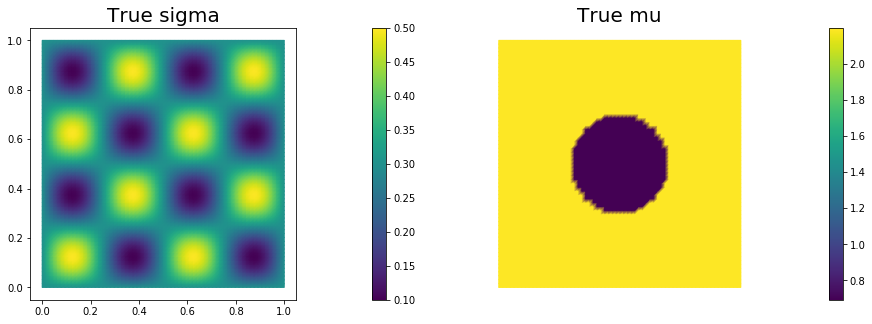

In [3]:
# TODO: Initialize these to the right values
# The true and inverted parameter
sigma_true = interpolate(Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=5),Vs)
sigma = interpolate(Expression('0.3', degree=2),Vs)

mu_true = interpolate(Expression('log(2 + 7*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2),0.5) > 0.2))', degree=5),Vs)
mu = interpolate(Expression('0.3', degree=2),Vs)

plt.figure(figsize=(15,5))
nb.plot(sigma_true, subplot_loc=121, mytitle="True sigma", show_axis='on')
nb.plot(mu_true, subplot_loc=122, mytitle="True mu")
plt.show()

In [25]:
# define function for state and adjoint
u = Function(Vu)
v = Function(Vu)

# define Trial and Test Functions
u_trial, v_trial, sigma_trial, mu_trial = TrialFunction(Vu), TrialFunction(Vu), TrialFunction(Vs), TrialFunction(Vs)
u_test, v_test, sigma_test, mu_test = TestFunction(Vu), TestFunction(Vu), TestFunction(Vs), TestFunction(Vs)

# Gruneisen coefficient
Gamma = Constant("1.0")

# diffusion coefficient
gamma = interpolate(Expression('0.03 + 0.01 * sin(x[1])', degree=3), Vs)

# true solution
u_true = Function(Vu)

kappa = 0.04

## Set up boundary conditions
The semilinear equation has given boundary values whereas the linear equation has homogeneous boundary conditions.

In [5]:
# TODO: bc with g defined by problem
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

g = Constant("1.0")
bc_state = DirichletBC(Vu, g, boundary)
bc_adj = DirichletBC(Vu, Constant(0.), boundary)


## Setting up synthetic observations

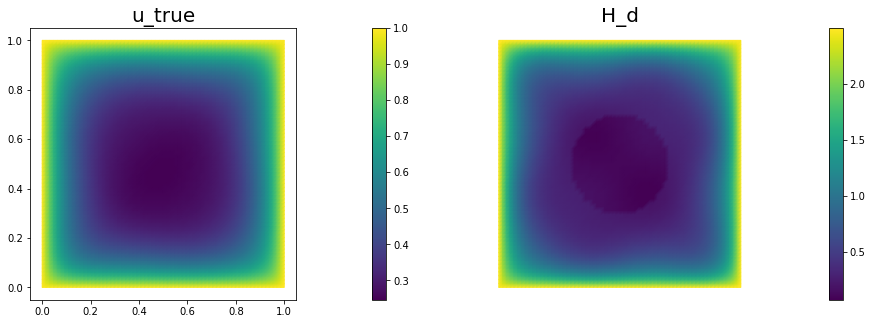

In [6]:
# Set the level of noise:
noise_level = 0.05

F_true = inner(gamma * nabla_grad(u_true), nabla_grad(u_test)) * dx + \
        sigma_true * u_true * u_test * dx + \
        mu_true * abs(u_true) * u_true * u_test * dx

solve(F_true == 0, u_true, bcs = bc_state, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})
# TODO: Proper noise addition as per paper
H_data = project(Gamma * sigma_true * u_true + Gamma * mu_true * u_true * abs(u_true), Vu)
MAX = H_data.vector().norm("linf")
noise = Vector()

plt.figure(figsize=(15,5))
nb.plot(u_true, subplot_loc=121, mytitle="u_true", show_axis='on')
nb.plot(H_data, subplot_loc=122, mytitle="H_d")
plt.show()

## Setting up the objective functional

In [32]:
def mismatch_cost(Gamma, sigma, mu, u, H):
    mismatch = Gamma * sigma * u + Gamma * mu * abs(u) * u - H
    return 0.5 * assemble(inner(mismatch, mismatch) * dx)

def regularization_cost(k, sigma, mu):
    reg_sigma = assemble(inner(grad(sigma),grad(sigma)) * dx)
    reg_mu = assemble(inner(grad(mu),grad(mu)) * dx) 
    return kappa * 0.5 * reg_sigma

def cost(Gamma, sigma, mu, u, H, k):
    return mismatch_cost(Gamma, sigma, mu, u, H_data) + regularization_cost(kappa, sigma, mu)

print (cost(Gamma, sigma, mu, u, H, k))

0.5603895708748267


## BFGS 

In [46]:
def gradient(gamma, sigma, mu, Gamma, u, v):
    '''
    Computes the gradient of the objective function with respect
    to sigma and mu
    '''

    # semilinear forward equation to obtain u
    forward_eq = inner(gamma * nabla_grad(u), nabla_grad(u_test)) * dx + \
        sigma * u * u_test * dx + \
        mu * abs(u) * u * u_test * dx

    solve(forward_eq == 0, u, bcs = bc_state)

    z = Gamma * (sigma * u + mu * abs(u) * u) - H_data

    # linear adjoint equation to obtain v
    adjoint_eq_bilinear = inner(gamma * nabla_grad(v_trial), nabla_grad(v_test)) * dx + \
        (sigma + 2 * mu * abs(u)) * v_trial * v_test * dx

    adjoint_eq_L = -z * Gamma * sigma * v_test * dx + 2 * mu * abs(u) * v_test * dx

    solve(adjoint_eq_bilinear == adjoint_eq_L, v, bc_adj)

    # use u and v obtain gradients of the objective function w.r.t. sigma and mu
    obj_d_sigma = z * Gamma * u * sigma_test * dx + v * u * sigma_test * dx  - \
        inner(kappa * nabla_grad(sigma), nabla_grad(sigma_test)) * dx

    obj_d_mu = z * Gamma * abs(u) * u * mu_test *  dx + v * abs(u) * u * mu_test * dx - \
        inner(kappa * nabla_grad(mu), nabla_grad(mu_test)) * dx
        
    return obj_d_sigma, obj_d_mu

def L_BFGS(sigma, mu):
    '''
    Limited memory BFGS quasi-Newton method implementation used to 
    solve the minimization problem arising from the least squares reconstruction method.
    For more information about the limited-memory BFGS method, refer to 
    Numerical Optimization by Nocedal and Wright
    '''
    k = 0
    m_MAX = 7
    m = 1
    s_sigma = deque()
    s_mu = deque()
    y_sigma = deque()
    y_mu = deque()
    rho_sigma = deque()
    rho_mu = deque()
    alpha_sigma = [] * m
    
    while converged:
        q_sigma, q_mu = gradient(gamma, sigma, mu, Gamma, u, v)
        # TODO: Conditions for convergence

        for i in range(0,m):
            alpha_sigma[i] = rho[i]_sigma *  s_sigma[i].inner(q_sigma)
            q_sigma = q_sigma - alpha_sigma[i] * y[i]
        
        gamma_k_sigma = s_sigma[-1].inner(y_sigma[-1])/y_sigma[-1].inner(y_sigma[-1])
        r_sigma = gamma_k_sigma * q_sigma
    
        gamma_k_sigma = s_sigma[-1].inner(y_sigma[-1])/y_sigma[-1].inner(y_sigma[-1])
        r_sigma = gamma_k_sigma * q_sigma
    
        gamma_k_mu = s_mu[-1].inner(y_mu[-1])/y_mu[-1].inner(y_mu[-1])
        r_mu = gamma_k_mu * q_mu

        for i in range(m-1,-1,-1):
            # Iterate backwards
            beta_sigma = rho_sigma[i] * y_sigma[i].inner(r_sigma)
            r_sigma = r_sigma + s_sigma[i]*(alpha_sigma[i] - beta) 

        p_sigma_k = -r_sigma
        p_mu_k = -r_mu

        # TODO: Satisfy Wolfe conditions for a
        sigma = sigma + a_sigma * p_sigma_k
        mu = mu + a_mu * p_mu_k





L_BFGS(sigma, mu)

0.005026602270107436
